In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make('BipedalWalker-v2')
env.seed(0)
print("Action dimension : ",env.action_space.shape)
print("State  dimension : ",env.observation_space.shape)
print("Action sample : ",env.action_space.sample())
print("State sample  : \n ",env.reset())

Action dimension :  (4,)
State  dimension :  (24,)
Action sample :  [0.09762701 0.43037874 0.20552675 0.08976637]
State sample  : 
  [ 2.74646818e-03  6.54533971e-06 -8.53474494e-04 -1.60000443e-02
  9.23600048e-02  1.98129308e-03  8.59931901e-01 -1.72333869e-04
  1.00000000e+00  3.27102654e-02  1.98121043e-03  8.53600875e-01
 -1.34810635e-03  1.00000000e+00  4.40813571e-01  4.45819676e-01
  4.61422324e-01  4.89549696e-01  5.34102261e-01  6.02460444e-01
  7.09148169e-01  8.85930896e-01  1.00000000e+00  1.00000000e+00]


In [3]:
class Actor(nn.Module):
    def __init__(self, state_size=24, action_size=4, fc_layer=64):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size= action_size
        self.Layer_in = nn.Linear(state_size, fc_layer)
        self.Layer_out= nn.Linear(fc_layer, action_size)
        
    def forward(self, state):
        x = F.relu(self.Layer_in(state))
        x = F.tanh(self.Layer_out(x))
        return x
    
class Critic(nn.Module):
    def __init__(self, state_size=24, action_size=4, fc1_layer=256, fc2_layer=128):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size= action_size
        self.Layer_1 = nn.Linear(state_size, fc1_layer)
        self.Layer_2 = nn.Linear(fc1_layer+action_size, fc2_layer)
        self.Layer_3 = nn.Linear(fc2_layer, 1)
        
    def forward(self, state, action):
        x = F.relu(self.Layer_1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.Layer_2(x))
        x = F.relu(self.Layer_3(x))
        return x    
    
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [4]:
buffer_size = int(1e6)
batch_size = 128
tau=0.999

class Agent():
    def __init__(self, state_size=24, action_size=4):
        self.state_size = state_size
        self.action_size = action_size   
        
        self.train_actor = Actor().to(device)
        self.target_actor= Actor().to(device)
        self.actor_optim = optim.Adam(self.train_actor.parameters(), lr=0.0001)
        
        self.train_critic = Critic().to(device)
        self.target_critic= Critic().to(device)
        self.critic_optim = optim.Adam(self.train_critic.parameters(), lr=0.0001)
        
        self.memory= ReplayBuffer(action_size= action_size, buffer_size= buffer_size, batch_size= batch_size)
        
    def learn_with_batches(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        if(len(self.memory)>batch_size):
            exp=self.memory.sample()
            self.learn(exp)
            
    def learn(self, exp):
        states, actions, rewards, next_states, done= exp
        
        #update critic
        next_actions = self.target_actor(next_states)
        Q_targets_next = self.target_critic(next_states, next_actions)
        
        Q_targets = rewards + (0.99 * Q_targets_next)
        
        Q_expected = self.train_critic(states, actions)
        
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
        
        #update actor
        actions_pred = self.train_actor(states)
        actor_loss = -self.train_critic(states, actions_pred).mean()
        
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        
        #using soft upates
        self.soft_update(self.train_actor, self.target_actor)
        self.soft_update(self.train_critic, self.target_critic)
        
            
    def get_action(self, state):
        state = torch.from_numpy(state).float().to(device)
        self.train_actor.eval()
        with torch.no_grad():
            action= self.train_actor(state).cpu().data.numpy()
        self.train_actor.train()
        return action
    
    def soft_update(self, local_model, target_model, tau=0.001):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [5]:
agent= Agent()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -108.15
Episode 200	Average Score: -115.56
Episode 300	Average Score: -111.66
Episode 400	Average Score: -107.01
Episode 500	Average Score: -102.13
Episode 600	Average Score: -104.88
Episode 700	Average Score: -96.71
Episode 800	Average Score: -92.36
Episode 900	Average Score: -95.48
Episode 1000	Average Score: -96.09
Episode 1100	Average Score: -102.82
Episode 1200	Average Score: -106.64
Episode 1300	Average Score: -94.07
Episode 1400	Average Score: -75.44
Episode 1500	Average Score: -70.50
Episode 1600	Average Score: -72.68
Episode 1700	Average Score: 19.58
Episode 1800	Average Score: 91.10
Episode 1900	Average Score: 93.20
Episode 2000	Average Score: 85.21
Episode 2100	Average Score: 134.04
Episode 2200	Average Score: 129.25
Episode 2215	Average Score: 124.08	Score: 201.33

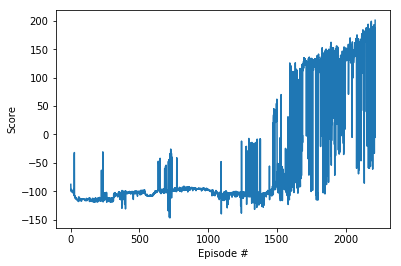

In [6]:
def ddpg(n_episodes=5000, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn_with_batches(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.train_actor.state_dict(), 'checkpoint_actorr.pth')
            torch.save(agent.train_critic.state_dict(), 'checkpoint_criticc.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque))) 
        if score >=200:
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
agent.train_actor.load_state_dict(torch.load('checkpoint_actorr.pth', map_location={'cuda:0': 'cpu'}))
agent.train_critic.load_state_dict(torch.load('checkpoint_criticc.pth', map_location={'cuda:0': 'cpu'}))

state = env.reset()
   
while True:
    action = agent.get_action(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
        
env.close()